In [1]:
!pip install tensorflow

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/fonttools-4.51.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/DimondPricePrediction-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [1]:
import numpy as np
import tensorflow as tf
import logging


mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


train_mask = (train_labels == 0) | (train_labels == 1)
test_mask = (test_labels == 0) | (test_labels == 1)

train_images_01 = train_images[train_mask]
test_images_01 = test_images[test_mask]
train_labels_01 = train_labels[train_mask]
test_labels_01 = test_labels[test_mask]


train_labels_01 = np.where(train_labels_01 == 0, -1, 1)
test_labels_01 = np.where(test_labels_01 == 0, -1, 1)


train_images_01 = train_images_01 / 255.0
test_images_01 = test_images_01 / 255.0


train_images_01 = train_images_01.reshape((-1, 28*28))
test_images_01 = test_images_01.reshape((-1, 28*28))


val_samples_per_class = 1000

train_indices_0 = np.where(train_labels_01 == -1)[0]
train_indices_1 = np.where(train_labels_01 == 1)[0]

np.random.shuffle(train_indices_0)
np.random.shuffle(train_indices_1)

val_indices_0 = train_indices_0[:val_samples_per_class]
val_indices_1 = train_indices_1[:val_samples_per_class]

train_indices_0 = train_indices_0[val_samples_per_class:]
train_indices_1 = train_indices_1[val_samples_per_class:]

train_images_train = np.concatenate([train_images_01[train_indices_0], train_images_01[train_indices_1]])
train_labels_train = np.concatenate([train_labels_01[train_indices_0], train_labels_01[train_indices_1]])

val_images = np.concatenate([train_images_01[val_indices_0], train_images_01[val_indices_1]])
val_labels = np.concatenate([train_labels_01[val_indices_0], train_labels_01[val_indices_1]])


train_indices = np.arange(train_images_train.shape[0])
np.random.shuffle(train_indices)
train_images_train = train_images_train[train_indices]
train_labels_train = train_labels_train[train_indices]


val_indices = np.arange(val_images.shape[0])
np.random.shuffle(val_indices)
val_images = val_images[val_indices]
val_labels = val_labels[val_indices]


print("Training images shape:", train_images_train.shape)
print("Training labels shape:", train_labels_train.shape)
print("Test images shape:", test_images_01.shape)
print("Test labels shape:", test_labels_01.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)


Training images shape: (10665, 784)
Training labels shape: (10665,)
Test images shape: (2115, 784)
Test labels shape: (2115,)
Validation images shape: (2000, 784)
Validation labels shape: (2000,)


In [2]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None

    def fit(self, X):
        X_centered = X - np.mean(X, axis=0)

        covariance_matrix = np.cov(X_centered, rowvar=False)

        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        self.components_ = sorted_eigenvectors[:, :self.n_components]

    def transform(self, X):
        return np.dot(X, self.components_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(train_images_train)
X_train_reduced = pca.transform(train_images_train)
X_val_reduced = pca.transform(val_images)
X_test_reduced=pca.transform(test_images_01)

In [3]:
# Define the DecisionStump class
class DecisionStump:
    def __init__(self):
        self.split_dim = None
        self.split_value = None
        self.y_left = None
        self.y_right = None
    
    def fit(self, X, y):
        best_split_dim, best_split_value, _ = self._find_best_split(X, y)
        self.split_dim = best_split_dim
        self.split_value = best_split_value
        
        left_indices = X[:, best_split_dim] <= best_split_value
        right_indices = ~left_indices
        
        self.y_left = np.mean(y[left_indices])
        self.y_right = np.mean(y[right_indices])
    
    def predict(self, X_test):
        predictions = np.zeros(X_test.shape[0])
        
        left_indices = X_test[:, self.split_dim] <= self.split_value
        right_indices = ~left_indices
        
        predictions[left_indices] = self.y_left
        predictions[right_indices] = self.y_right
        
        return predictions
    
    def _find_best_split(self, X, y):
        best_split_dim = None
        best_split_value = None
        best_ssr = float('inf')

        for dim in range(X.shape[1]):
            unique_values = np.unique(X[:, dim])
            sorted_values = np.sort(unique_values)
            
            midpoints = (sorted_values[:-1] + sorted_values[1:]) / 2
            
            for split_value in midpoints:
                left_indices = X[:, dim] <= split_value
                right_indices = ~left_indices
                
                left_y = y[left_indices]
                right_y = y[right_indices]
                
                left_ssr = np.sum((left_y - np.mean(left_y)) ** 2)
                right_ssr = np.sum((right_y - np.mean(right_y)) ** 2)
                total_ssr = left_ssr + right_ssr
                
                if total_ssr < best_ssr:
                    best_ssr = total_ssr
                    best_split_dim = dim
                    best_split_value = split_value
        
        return best_split_dim, best_split_value, best_ssr

def compute_gradients(y_true, y_pred):
    return np.sign(y_true - y_pred)

def update_labels(y_true, y_pred, learning_rate=0.01):
    gradients = compute_gradients(y_true, y_pred)
    updated_labels = y_pred + learning_rate * gradients
    return updated_labels
def ensemble_predict(X, models):
    predictions = np.zeros(X.shape[0])
    for model in models:
        predictions += model.predict(X)
    return predictions


model = DecisionStump()
model.fit(X_train_reduced, train_labels_train)
h1 = model.predict(X_train_reduced)
print(train_labels_train-0.01*h1)



[ 0.99008358 -0.99009346  0.99008358 ...  0.99008358 -0.99009346
 -0.99009346]


In [4]:
update_lb=update_labels(train_labels_train,h1)
model2 = DecisionStump()
model2.fit(X_train_reduced, update_lb)
h2=model2.predict(X_train_reduced)
print(train_labels_train-0.01*h1-0.01*h2)

[ 0.980068   -0.98008785  0.980068   ...  0.980068   -0.98008785
 -0.98008785]


In [ ]:
logging.basicConfig(filename='mse_val.log', level=logging.INFO, format='%(message)s')
n_stumps=300
mse_l=[]
dt_stumps=[]
for i in range(n_stumps):
    model=DecisionStump()
    if i==0: ul=train_labels_train
    else: ul=update_labels(train_labels_train,ensemble_predict(X_train_reduced,dt_stumps))
    model.fit(X_train_reduced, ul)
    dt_stumps.append(model)
    pred=ensemble_predict(X_val_reduced,dt_stumps)
    mse_val=np.mean((pred-val_labels)**2)
    mse_l.append(mse_val)
    print("Iteration:", i+1, "MSE on Validation Set:", mse_val)
    logging.info(f"Iteration:{i+1},MSE on Validation Set: {mse_val}")

Iteration: 1 MSE on Validation Set: 0.02386419638289421
Iteration: 2 MSE on Validation Set: 1.0322821503907285
Iteration: 3 MSE on Validation Set: 8.942505146992133
Iteration: 4 MSE on Validation Set: 48.33779367882697
Iteration: 5 MSE on Validation Set: 221.42774089702476
Iteration: 6 MSE on Validation Set: 944.8051159515326
Iteration: 7 MSE on Validation Set: 3900.3497885329975
Iteration: 8 MSE on Validation Set: 15846.598823585728
Iteration: 9 MSE on Validation Set: 63879.735653250355
Iteration: 10 MSE on Validation Set: 256508.56435081642
Iteration: 11 MSE on Validation Set: 1028016.4418988958
Iteration: 12 MSE on Validation Set: 4116033.077606843
Iteration: 13 MSE on Validation Set: 16472069.871469893
Iteration: 14 MSE on Validation Set: 65904157.54898457
Iteration: 15 MSE on Validation Set: 263648389.26316848
Iteration: 16 MSE on Validation Set: 1054657078.1281536
Iteration: 17 MSE on Validation Set: 4218755357.6045947
Iteration: 18 MSE on Validation Set: 16875275523.543364
Itera

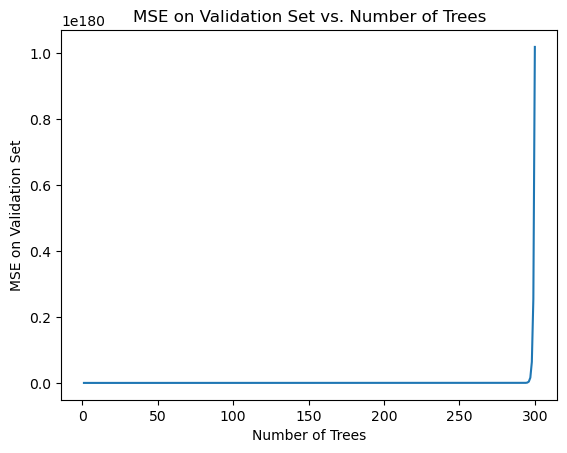

In [33]:
best_model_idx=np.argmin(mse_l)
plt.plot(range(1, 301), mse_l)
plt.xlabel('Number of Trees')
plt.ylabel('MSE on Validation Set')
plt.title('MSE on Validation Set vs. Number of Trees')
plt.show()


In [34]:
y_pred_test=ensemble_predict(X_test_reduced,dt_stumps[:best_model_idx+1])
mse_test = np.mean((y_pred_test - test_labels_01) ** 2)
print("Test MSE for the best model:", mse_test)

Test MSE for the best model: 0.015075012649036337
